# Hyperparameters

| hyperparameter|ESOL|FP|AIT|FLVL|FLVU|HCOM|
|--------------:|---:|-:|--:|---:|---:|---:|
| hidden_size | 91 | 84 | 65 | 63 | 68 | 64 |
| dropout | 0.282 | 0.360 | 0.266 | 0.362 | 0.335 | 0.435 |
| num_layers | 2 | 4 | 4 | 3 | 2 | 4 |
| num_timesteps | 4 | 4 | 4 | 3 | 3 | 4 |
| lr_init | 0.01 | 0.01 | 0.01 | 0.01 | 0.001 | 0.01 |
| gamma | 0.980 | 0.994 | 0.995 | 0.982 | 0.995 | 0.995 |
| weight_decay | 6.0 $\times$ 10$^{-5}$ | 3.5 $\times$ 10$^{-3}$ | 1.8 $\times$ 10$^{-3}$ | 1.3 $\times$ 10$^{-2}$ | 1.2 $\times$ 10$^{-3}$ | 2.7 $\times$ 10$^{-3}$ |

# Parameter Setting

In [1]:
parameters = dict(
    subfrag_size = 12,
    edge_size = 3,
    out_size = 1,
    seed = 42,
    batch_size = 256,
    max_epoch = 200,
    verbose = True,
    save = False,
    
    target = 'FLVL',
    hidden_size = 63,
    dropout = 0.362,
    num_layers = 3,
    num_timesteps = 3,
    lr_init = 0.01,
    gamma = 0.982,
    weight_decay = 1.3E-2,
)

DATAPATH = "__YOUR_DATA_ROOT__"
MODELPATH = "../Model/__YOUR_MODEL_ROOT__"

# Serotonin
# SMILES = "C1=CC2=C(C=C1O)C(=CN2)CCN"; TRUE_VAL = 205.4 + 273.15
# Cinnamaldehyde
# SMILES = "O=CC=Cc1ccccc1"; TRUE_VAL = 71 + 273.15
# 1,1'-(1,3-Phenylene)bis(1H-pyrrole-2,5-dione)
# SMILES = "CC1=CC(=O)N(C1=O)CC2=CC(=CC=C2)CN3C(=O)C=C(C3=O)C"; TRUE_VAL = 250.7 + 273.15
# Adrenosterone
# SMILES = "CC12CCC(=O)C=C1CCC3C2C(=O)CC4(C3CCC4=O)C"; TRUE_VAL = 206.0 + 273.15

# 4-Nitrotoluene
# SMILES = "O=[N+]([O-])c1ccc(C)cc1"; TRUE_VAL = 379 # FP
SMILES = "O=[N+]([O-])c1ccc(C)cc1"; TRUE_VAL = 1.6 # FLVL

SYMBOL = dict([(1, "H"), (6, "C"), (8, "O"), (7, "N"), (0, "*")]) # Atomic Symbol

# Prediction

In [2]:
import sys
sys.path.append(DATAPATH)
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

from src.data import Dataset
from src.smiles2data import smiles2data
from src.model import Chemomile
from src.explainer import Explainer

In [3]:
dataset = Dataset(target = parameters['target'],
                  root = DATAPATH)
data = smiles2data(SMILES, TRUE_VAL)

model = Chemomile(
            subfrag_size = parameters['subfrag_size'],
            hidden_size = parameters['hidden_size'],
            out_size = parameters['out_size'],
            edge_size = parameters['edge_size'],
            dropout = parameters['dropout'],
            num_layers = parameters['num_layers'],
            num_timesteps = parameters['num_timesteps'],
            )
model.load_state_dict(torch.load(MODELPATH))
model.eval()

	DataDump found for 'FLVL'. Loading dumped data.
Training : 372 | Validation : 46 | Test : 47
Total : 465


Chemomile(
  (subfrag_level): AttentiveFP(in_channels=12, hidden_channels=126, out_channels=63, edge_dim=3, num_layers=3, num_timesteps=3)
  (fragment_level): AttentiveFP(in_channels=63, hidden_channels=126, out_channels=63, edge_dim=3, num_layers=3, num_timesteps=3)
  (molecule_level): AttentiveFP(in_channels=12, hidden_channels=126, out_channels=63, edge_dim=3, num_layers=3, num_timesteps=3)
  (fully_connected): Sequential(
    (0): Linear(in_features=126, out_features=63, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.362, inplace=False)
    (3): Linear(in_features=63, out_features=1, bias=True)
  )
)

In [4]:
explainer = Explainer(
    model = model,
    data = data
)

pred = explainer.ref * dataset.std + dataset.mean

nameset = [data.smiles for data in dataset.total_set]

if SMILES in nameset:
    print(f"{SMILES} is already in the dataset.")
print(f"| SMILES : {data.smiles} | TRUE : {data.y:.3f} | PRED : {pred:.3f} |")

| SMILES : O=[N+]([O-])c1ccc(C)cc1 | TRUE : 1.600 | PRED : 1.528 |


# Explain

In [5]:
score = explainer.atomMask()
score

[0.0035074353218078613,
 0.020769059658050537,
 0.00396960973739624,
 0.012274742126464844,
 0.021052658557891846,
 0.020940840244293213,
 0.011536777019500732,
 0.01752912998199463,
 0.0196724534034729,
 0.019311249256134033,
 0.008459866046905518,
 0.008144617080688477,
 0.004101157188415527,
 0.004363298416137695,
 0.004040718078613281,
 0.007586538791656494,
 0.008599579334259033]

# Visualization

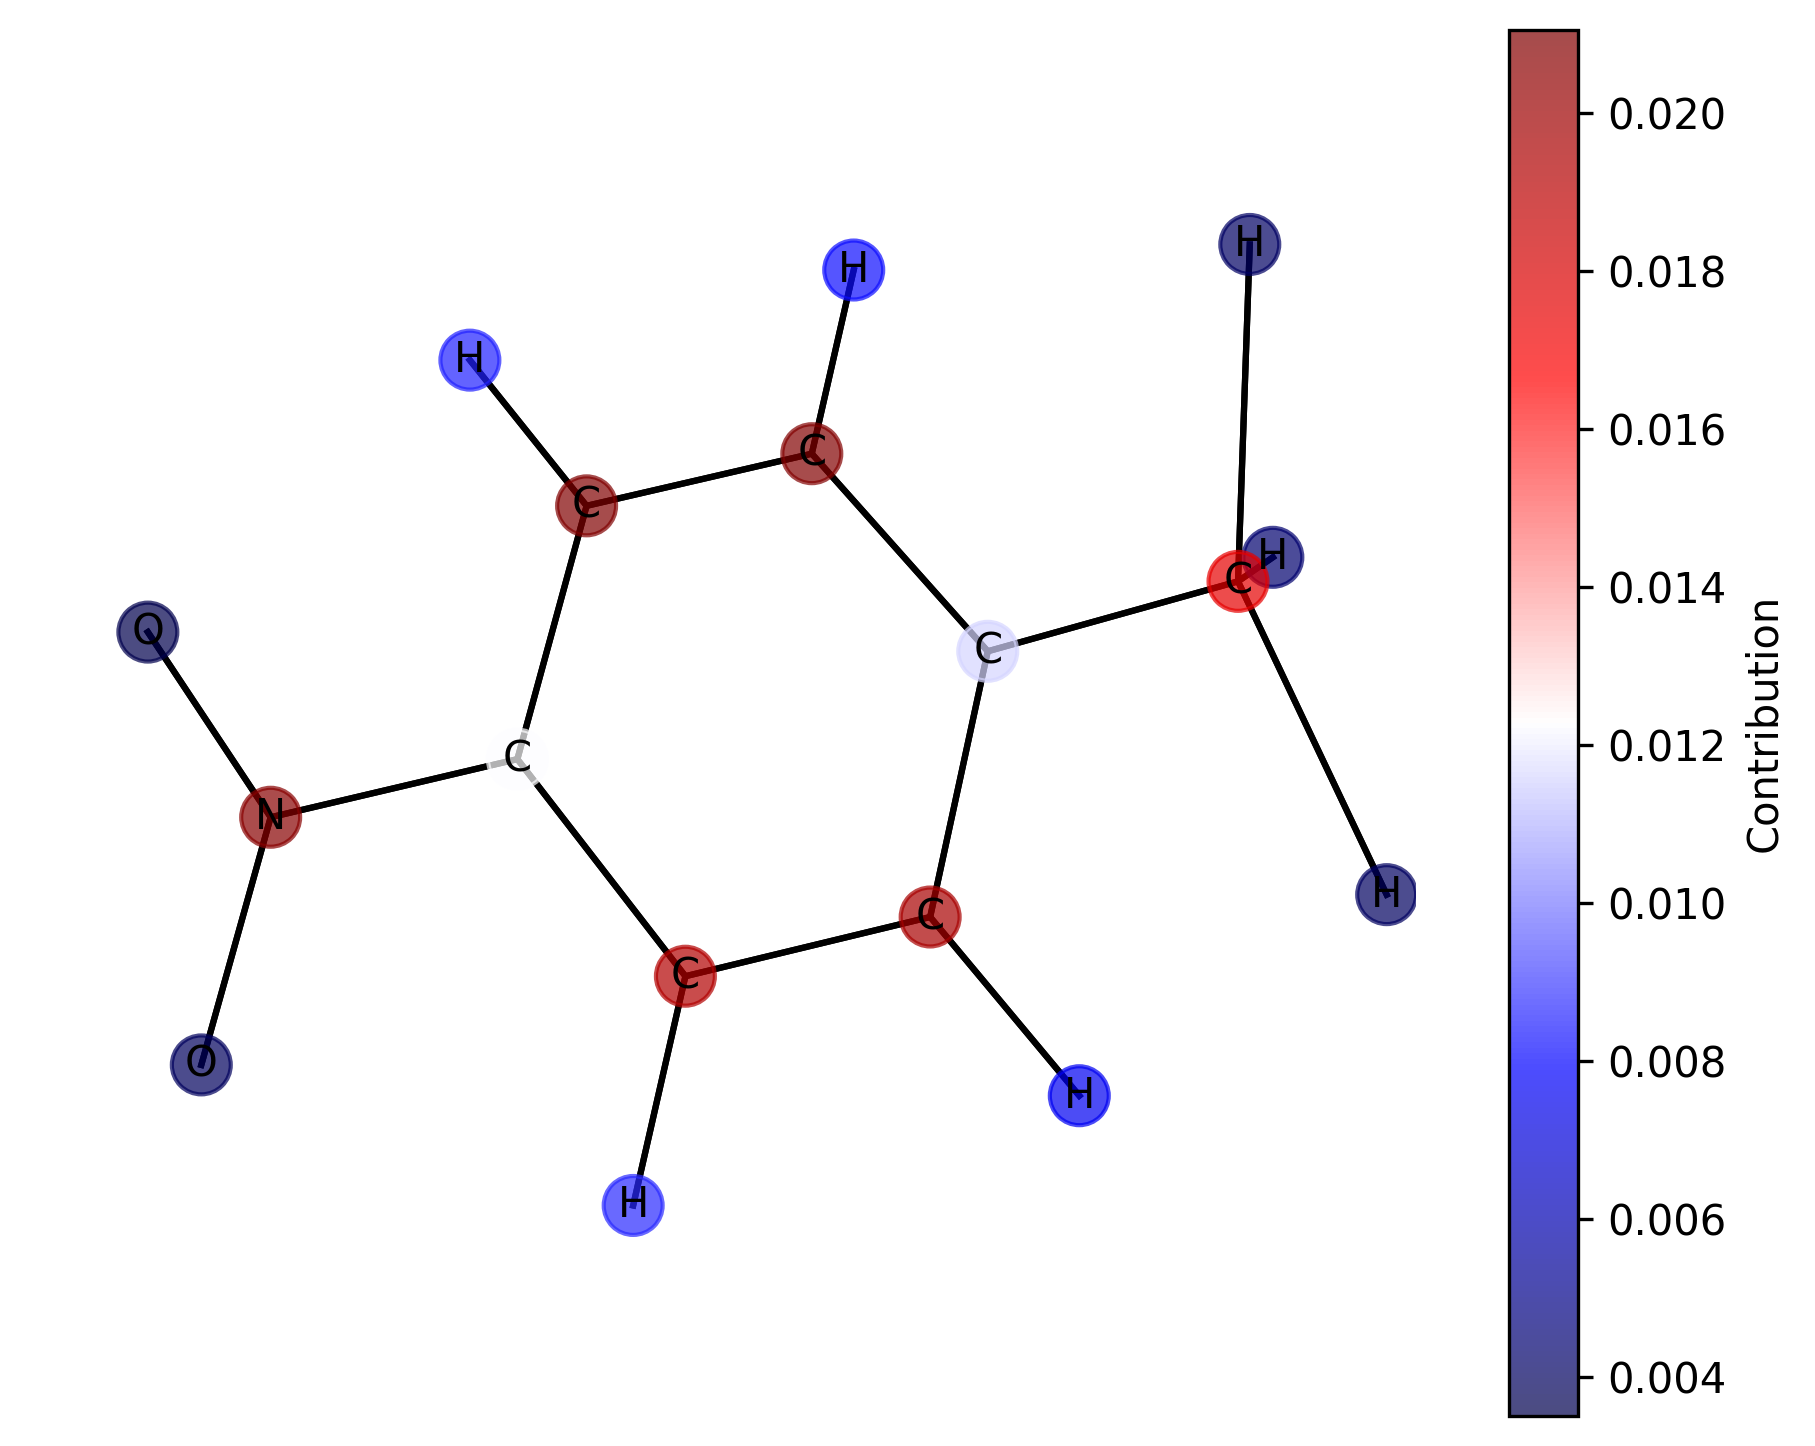

In [6]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (8, 6), dpi = 300,
                       subplot_kw = dict(projection = '3d'))

p = explainer.plot(ax)

ax.dist = 100

ax.view_init(azim = -100, elev = 73, roll = 0)
ax.set_box_aspect(None, zoom = 1.5)

fig.colorbar(p, label = "Contribution")

plt.show()